In [1]:
import pandas as pd
import string
import numpy as np
import spacy
from html.parser import HTMLParser
from spacy.lang.en import English
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import ngrams
import re
import gensim
from gensim import corpora
import pyLDAvis.gensim
from gensim.models import CoherenceModel
from gensim.models.wrappers import LdaMallet
from gensim.models import Phrases
from gensim.models.phrases import Phraser 
import pickle
from collections import OrderedDict
import matplotlib.pyplot as plt
import os
import datetime as dt
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import seaborn as sns; sns.set_style("whitegrid"); sns.set_palette("Set2")
import matplotlib.pyplot as plt 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
df = pd.read_csv('C:/Users/josh.a.peters/TransitSocialMedia/Data/reddit_df_topics.csv')

In [3]:
df['topic'] = df['topic'] + 1

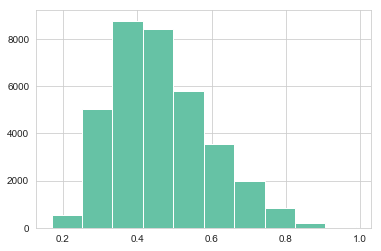

In [4]:
df['topic_pct'].hist()

In [5]:
df['topic'].value_counts()

6    14172
4    11335
8     2576
5     2052
3     1853
7     1482
9      808
1      420
2      387
Name: topic, dtype: int64

In [6]:
top_topics = df[df['topic_pct'] > 0.5]

In [7]:
len(top_topics)

12072

In [8]:
top_topics['topic'].value_counts()

6    6319
4    3909
8     573
3     464
5     459
7     220
9      74
1      36
2      18
Name: topic, dtype: int64

In [12]:
df["body_clean"] = df["body"].apply(lambda x: clean_text(x))

In [15]:
df_clean = clean_html(df)

In [23]:
df_clean.to_csv('C:/Users/josh.a.peters/Desktop/df_topics_updated.csv')

In [ ]:
df_clean['title_clean'] = df["body"].apply(lambda x: clean_text(x))

In [19]:
getTFIDFandCount(df_clean[df_clean['topic'] == 8]['body_clean'], (3,3))

,term,tfidf,counts
0,raise property tax,0.008777,27
1,they re go,0.007393,19
2,public transit system,0.007366,21
3,use public transit,0.007045,20
4,transit tax credit,0.006639,18
5,gas station owner,0.005626,16
6,low income people,0.005230,15
7,https enwikipediaorg wiki,0.004893,23
8,we re go,0.004623,14
9,land transfer tax,0.004318,13


In [20]:
getTFIDFandCount(df_clean[df_clean['topic'] == 4]['body_clean'], (3,3))

,term,tfidf,counts
0,they re go,0.002867,34
1,ttc bus driver,0.002215,26
2,couple year ago,0.001985,23
3,take go train,0.001897,22
4,gas station owner,0.001861,22
5,use public transit,0.001772,21
6,we re go,0.001772,23
7,take public transit,0.001683,20
8,ttc fare inspector,0.001683,20
9,ve never see,0.001657,19


In [21]:
getTFIDFandCount(df_clean[df_clean['topic'] == 1]['body_clean'], (3,3))
    

,term,tfidf,counts
0,high suicide rate,0.010146,5
1,take public transit,0.009547,4
2,mental health issue,0.008876,5
3,late term abortion,0.008872,8
4,adult gender identity,0.003648,6
5,process sex reassignment,0.003648,6
6,provide basic necessity,0.003358,7
7,sex reassignment surgery,0.003126,4
8,suggest sex reassignment,0.002985,5
9,basic necessity life,0.002908,6


In [10]:
def getTFIDFandCount(df_col, ngramrange):
    """(DataFrame, tuple --> DataFrame)
    Takes a column of a dataframe and the range for n-gram analysis to find the TF-IDF for each
    n-gram in the column.

    Returns a DataFrame of the top 10 n-grams, TF-IDF score, and actual count of n-gram appearance.
    """
    cv=CountVectorizer(ngram_range=ngramrange, max_features=15)
    word_count_vector=cv.fit_transform(df_col.unique())
    feature_names = cv.get_feature_names()

    # Transforming top 400 most common words to produce TF-IDF score
    tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
    tfidf_transformer.fit(word_count_vector)
    tfidf_vector=tfidf_transformer.transform(word_count_vector)

    # Combining TF-IDF score with the words into a dictionary
    weights = np.asarray(tfidf_vector.mean(axis=0)).ravel().tolist()
    df_tfidf = pd.DataFrame(weights, index=feature_names, columns=["tfidf"])
    df_tfidf = df_tfidf.sort_values(by=["tfidf"],ascending=False).reset_index()
    df_tfidf.rename(index=str, columns={"index": "term"}, inplace=True)

    # Counting the actual number of occurances and appending to dictionary of word
    # with TF-IDF value
    count_list = word_count_vector.toarray().sum(axis=0)
    actual_count_dict = {"term": feature_names, "counts": count_list}
    actual_count_df = pd.DataFrame.from_records(actual_count_dict)
    tfidf_and_count = pd.merge(df_tfidf, actual_count_df, on='term', how='left')
    return tfidf_and_count

def add_tfidf_column(full_df, month, suffix):
    """(DataFrame, string, string --> DataFrame)
    Takes the filtered dataframe to generate TFIDF scores for, as well as the month
    and suffix relating to what the dataframe has been filtered for (i.e. mental health
    or sarcastic posts).

    Returns the top 10 TFIDF for the filtered dataframe, for that month.
    """
    tfidf_df = getTFIDFandCount(full_df["Post_Clean"],(2, 4))
    tfidf_df = tfidf_df[:10]
    tfidf_df = tfidf_df.add_suffix(suffix)
    return tfidf_df

def create_monthly_tfidf(full_df):
    """(DataFrame --> DataFrame)
    Taking the Reddit dataframe and combining it with the dataframe of TF-IDF values
    so each month is matched up with the most popular TF-IDFs for that month.

    Returns a dataframe with a new column for most popular TF-IDFs of that month.
    """
    all_tfidf = pd.DataFrame()
    # Filters out empty posts as well as mental health monday posts, since they
    # skew the popular word count

    full_df = full_df[~full_df["Post_Clean"].isnull()]
    full_df = full_df[~full_df["Post_Clean"].str.contains("mental health monday")]

    # Getting the unique month and years for the reddit data and iterating through
    # each month-year combination
    all_time = full_df.yearmonth_sub.unique()
    for month in all_time:
        filtered = full_df[full_df.yearmonth_sub == month]
        # Generate top 10 monthly TF-IDF for all posts
        tfidf_df = getTFIDFandCount(filtered["Post_Clean"],(2, 4))
        tfidf_df = tfidf_df[:10]
        tfidf_df["yearmonth_sub"] = month
        # Generate top 10 monthly TF-IDF for all MH posts
        mh_filtered = filtered[filtered.mh_combined_updated > 0.7]
        if len(mh_filtered) > 1:
            mh_tfidf_df = add_tfidf_column(mh_filtered, month, '_mh')
            tfidf_df = pd.concat([tfidf_df, mh_tfidf_df], axis=1, sort=True)
        # Generate top 10 monthly TF-IDF for all sarcastic posts
        sarc_filtered = filtered[filtered.prob_sarc > 0.8]
        if len(sarc_filtered) > 1:
            sarc_tfidf_df = add_tfidf_column(sarc_filtered, month, '_sarc')
            tfidf_df = pd.concat([tfidf_df, sarc_tfidf_df], axis=1, sort=True)
        # Adding filtered TFIDF columns to master TFIDF dataframe with the top
        # terms for all posts
        all_tfidf = all_tfidf.append(tfidf_df, ignore_index=True, sort=True)
        
    return all_tfidf
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def clean_text(text):
    # lower text
    text = str(text).lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    text = re.sub(r'([.,?!*()])', "", text)
    return(text)


In [11]:
def clean_html(df_subs_clean):
    """
    (Dataframe --> DataFrame)
    Cleans up any redit values that were not converted propoerly from html or utf - 8 when pulled from the internet

    """
    #define class that strips html using html parser
    class MLStripper(HTMLParser):
        def __init__(self):
            self.reset()
            self.strict = False
            self.convert_charrefs= False
            self.fed = []
        def handle_data(self, d):
            self.fed.append(d)
        def get_data(self):
            return ''.join(self.fed)
    #define function that calls stripper
    def strip_tags(html):
        s = MLStripper()
        s.feed(html)
        return s.get_data()


    #apply encoding from windows to utf to get some garbage characters
    df_subs_clean['body_clean'] = df_subs_clean['body_clean'].str.encode("Windows-1252", 'ignore').str.decode('utf-8', 'ignore').str.replace('#x200B;',"")
    #apply htm function
    df_subs_clean['body_clean'] = df_subs_clean['body_clean'].astype(str).str.replace('\n', "").apply(strip_tags)
    df_subs_clean['body_clean'] = df_subs_clean['body_clean'].astype(str).str.replace('\r', "").apply(strip_tags)


    return df_subs_clean
